## Background

Dataset taken from https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice

## Loading data

In [1]:
import pandas as pd

column_names = [
    'wife_age',
    'wife_edu',
    'husb_edu',
    'children',
    'wife_rel',
    'wife_isw',
    'husb_ocu',
    'sol_index',
    'media_exp',
    'method_used'
]

df = pd.read_csv('cmc.data', names=column_names)
df.head()

,wife_age,wife_edu,husb_edu,children,wife_rel,wife_isw,husb_ocu,sol_index,media_exp,method_used
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


## Preparing Data

In [2]:
features = [col for col in column_names if col != 'method_used']

X = df[features]
y = df['method_used']

### Scaling

I'm using a StandardScaler

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X      = scaler.fit_transform(X)

### Feature selection
First I'd like to see how balanced are the target classes

In [4]:
df.loc[:, ['media_exp', 'method_used']]\
    .groupby('method_used')\
    .count()\
    .reset_index()

,method_used,media_exp
0,1,629
1,2,333
2,3,511


In [5]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install -U imbalanced-learn

In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='all')
X, y  = smote.fit_resample(X, y)

Now I'm using SelectKBest method to get the best 5 features

In [7]:
from sklearn.feature_selection import SelectKBest, f_classif

N             = 9
fs            = SelectKBest(f_classif, k=N)
X_selected    = fs.fit_transform(X, y)
cols          = fs.get_support(indices=True)
df_improved   = df.iloc[:, cols]
feature_names = df.iloc[:, cols].columns.values

print("Top {} features: {}".format(N, feature_names))

Top 9 features: ['wife_age' 'wife_edu' 'husb_edu' 'children' 'wife_rel' 'wife_isw'
 'husb_ocu' 'sol_index' 'media_exp']


### Create training/test sets

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Model creation

In [9]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC

classifiers = [
    {
        'classifier': SVC(),
        'params': {
            'C': [1, 5, 10, 20, 30, 40]
        }
    },
    {
        'classifier': LogisticRegression(),
        'params': {
            'C': [1, 5, 10, 20, 30, 40],
            'solver': ['newton-cg', 'saga']
        }
    },
    {
        'classifier': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 10, 15, 20]
        }
    },
    {
        'classifier': DecisionTreeClassifier(),
        'params': {
            'max_depth': [3, 4, 5, 6]
        }
    },
    {
        'classifier': RandomForestClassifier(),
        'params': {
            'max_depth': [3, 4, 5, 6]            
        }
    },
    {
        'classifier': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 60, 75, 100]
        }
    }
] 

In [10]:
from sklearn.model_selection import GridSearchCV

def resolve_best_params(classifier_entry, X_param, y_param):
    clsf_instance = classifier_entry['classifier']
    clsf_params   = classifier_entry['params']
    grid_search   = GridSearchCV(
        clsf_instance, 
        cv=5,
        param_grid=clsf_params, 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        scoring='precision_macro')
    grid_result   = grid_search.fit(X_param, y_param)
    
    return grid_result.best_params_

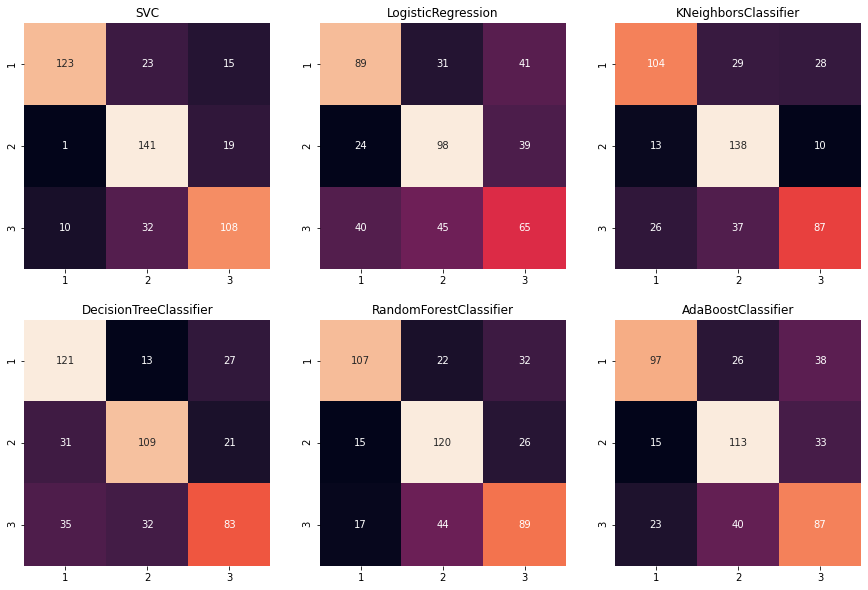

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(2, 3, figsize=(15, 10))
cols  = 0
rows  = 0

for clsf in classifiers:    
    best_params = resolve_best_params(clsf, X, y)
    classifier  = clsf['classifier'].set_params(**best_params).fit(X, y)
    clsf_name   = type(classifier).__name__
    
    y_predicted = classifier.predict(X_test)
    matrix      = confusion_matrix(y_test, y_predicted)
    dataframe   = pd.DataFrame(matrix, index=[1, 2, 3], columns=[1, 2, 3])

    ax[rows, cols].title.set_text(clsf_name)
    sns.heatmap(dataframe, cbar=False, square=True, annot=True, fmt='g',ax=ax[rows, cols])
    if cols < 2:
        cols += 1
    else:
        cols = 0
        rows +=1

plt.show()

In [12]:
from sklearn.metrics import classification_report

for clsf in classifiers:    
    best_params = resolve_best_params(clsf, X, y)
    classifier  = clsf['classifier'].set_params(**best_params).fit(X, y)
    clsf_name   = type(classifier).__name__
    y_predicted = classifier.predict(X_test)
    report_result = classification_report(y_test, y_predicted)
    
    print()
    print("{} -- {}".format(clsf_name, best_params))
    print('-------------------------------------------------------')
    print()
    print(report_result)
    print()


SVC -- {'C': 40}
-------------------------------------------------------

              precision    recall  f1-score   support

           1       0.92      0.76      0.83       161
           2       0.72      0.88      0.79       161
           3       0.76      0.72      0.74       150

    accuracy                           0.79       472
   macro avg       0.80      0.79      0.79       472
weighted avg       0.80      0.79      0.79       472



LogisticRegression -- {'C': 1, 'solver': 'newton-cg'}
-------------------------------------------------------

              precision    recall  f1-score   support

           1       0.58      0.55      0.57       161
           2       0.56      0.61      0.59       161
           3       0.45      0.43      0.44       150

    accuracy                           0.53       472
   macro avg       0.53      0.53      0.53       472
weighted avg       0.53      0.53      0.53       472



KNeighborsClassifier -- {'n_neighbors': 5}
-----